# Polymarket Trading Analysis

This notebook analyzes trading activity to identify the most profitable and least profitable markets.

## Configuration

In [1]:
import os
import sys
from datetime import datetime, timedelta
import pandas as pd
import requests
from typing import List, Dict
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv

# Load environment variables
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))))
load_dotenv()

# Configure matplotlib for better-looking plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

In [2]:
# ===== CONFIGURATION PARAMETERS =====

# Wallet address to analyze
WALLET_ADDRESS = os.getenv('BROWSER_ADDRESS')

# Timeframe configuration (Unix timestamps)
# Default: Last 30 days
END_DATE = datetime.now()
START_DATE = END_DATE - timedelta(days=30)

# Convert to Unix timestamps (seconds)
START_TIMESTAMP = int(START_DATE.timestamp())
END_TIMESTAMP = int(END_DATE.timestamp())

# API Configuration
API_BASE_URL = 'https://data-api.polymarket.com'
REQUEST_LIMIT = 500  # Max results per request

print(f"Analyzing wallet: {WALLET_ADDRESS}")
print(f"Date range: {START_DATE.strftime('%Y-%m-%d')} to {END_DATE.strftime('%Y-%m-%d')}")
print(f"Timestamp range: {START_TIMESTAMP} to {END_TIMESTAMP}")

Analyzing wallet: 0xC3dA2b26f845d799B9d456828753f5a3af57d974
Date range: 2025-09-24 to 2025-10-24
Timestamp range: 1758748038 to 1761340038


## Data Collection

In [3]:
def fetch_trading_activity(wallet_address: str, start: int, end: int) -> List[Dict]:
    """
    Fetch all trading activity for a wallet within the specified timeframe.
    
    Args:
        wallet_address: Ethereum wallet address
        start: Start timestamp (Unix seconds)
        end: End timestamp (Unix seconds)
    
    Returns:
        List of trading activity records
    """
    all_activities = []
    offset = 0
    
    while True:
        params = {
            'user': wallet_address,
            'type': 'TRADE',
            'limit': REQUEST_LIMIT,
            'offset': offset,
            'start': start,
            'end': end,
            'sortBy': 'TIMESTAMP',
            'sortDirection': 'DESC'
        }
        
        try:
            response = requests.get(f'{API_BASE_URL}/activity', params=params)
            response.raise_for_status()
            
            activities = response.json()
            
            if not activities or len(activities) == 0:
                break
            
            all_activities.extend(activities)
            
            print(f"Fetched {len(activities)} activities (offset: {offset}, total: {len(all_activities)})")
            
            # Check if we've reached the end
            if len(activities) < REQUEST_LIMIT:
                break
            
            offset += REQUEST_LIMIT
            
        except requests.exceptions.RequestException as e:
            print(f"Error fetching data: {e}")
            break
    
    print(f"\nTotal activities fetched: {len(all_activities)}")
    return all_activities

In [4]:
# Fetch all trading activity
activities = fetch_trading_activity(WALLET_ADDRESS, START_TIMESTAMP, END_TIMESTAMP)

if not activities:
    print("⚠️ No trading activity found in the specified timeframe")
else:
    print(f"✅ Successfully fetched {len(activities)} trades")

Fetched 256 activities (offset: 0, total: 256)

Total activities fetched: 256
✅ Successfully fetched 256 trades


## Data Processing

In [17]:
# Convert to DataFrame for easier analysis
df = pd.DataFrame(activities)

# Display basic information
print(f"Total trades: {len(df)}")
print(f"\nColumns available: {list(df.columns)}")
print(f"\nFirst few rows:")
df.head()

Total trades: 256

Columns available: ['proxyWallet', 'timestamp', 'conditionId', 'type', 'size', 'usdcSize', 'transactionHash', 'price', 'asset', 'side', 'outcomeIndex', 'title', 'slug', 'icon', 'eventSlug', 'outcome', 'name', 'pseudonym', 'bio', 'profileImage', 'profileImageOptimized']

First few rows:


,proxyWallet,timestamp,conditionId,type,size,usdcSize,transactionHash,price,asset,side,...,title,slug,icon,eventSlug,outcome,name,pseudonym,bio,profileImage,profileImageOptimized
0,0xc3da2b26f845d799b9d456828753f5a3af57d974,1761339614,0x9de057f5311ae2f8209facceb3e4b6b392ea3a9e6db4...,TRADE,119.210000,28.610400,0xe631e13d01e2a0cf21fb83dc2e1925e27eee4fb5c3c6...,0.24,7824354098474336348001811840139290561282101065...,SELL,...,Will Abigail Spanberger win by 6-9%?,will-abigail-spanberger-win-by-6-9,https://polymarket-upload.s3.us-east-2.amazona...,virginia-governor-election-margin-of-victory,Yes,alcaudi,Meaty-Prevalence,,,
1,0xc3da2b26f845d799b9d456828753f5a3af57d974,1761339584,0xd7bdb9ea209753809848cc73c51ad714a4a84660dd72...,TRADE,100.000000,18.000000,0xd712de1c9670b31d570a95a10da8b2e7bc94b7f959f0...,0.18,7384751144950562490161778843716429108243585985...,BUY,...,Will Russia capture Kupiansk by November 30?,will-russia-capture-kupiansk-by-november-30,https://polymarket-upload.s3.us-east-2.amazona...,will-russia-capture-kupiansk-by,No,alcaudi,Meaty-Prevalence,,,
2,0xc3da2b26f845d799b9d456828753f5a3af57d974,1761339196,0x7d98815be880769be11a63b4df815b9bdcbf6ae007a8...,TRADE,1.351350,0.351351,0x4d214d82ede6e9ff5e2e6a4b6fc97bdb44b9bd40039e...,0.26,5670092057077261135244767107264566108124729767...,BUY,...,Will Google have the top AI model on December 31?,which-company-has-best-ai-model-end-of-2025,https://polymarket-upload.s3.us-east-2.amazona...,which-company-has-best-ai-model-end-of-2025,No,alcaudi,Meaty-Prevalence,,,
3,0xc3da2b26f845d799b9d456828753f5a3af57d974,1761338542,0x8d3b0c55b590786ca889e68a0005ea626f5f8b856e1d...,TRADE,67.000000,8.040000,0xe68a5d6682d0139080acc5d2bbed2c3851e1e8571be2...,0.12,4534963287879555869274113579013121803597881829...,SELL,...,Will the Party for Freedom win the second most...,will-the-party-for-freedom-win-the-second-most...,https://polymarket-upload.s3.us-east-2.amazona...,which-party-wins-2nd-most-seats-in-netherlands...,Yes,alcaudi,Meaty-Prevalence,,,
4,0xc3da2b26f845d799b9d456828753f5a3af57d974,1761335648,0xd1796c09d0d6f876f8580086ae9808ec991784e3a74b...,TRADE,14.285713,8.285714,0x2ddd6df7048d62fe2734cbca50e9c2ce6bb0fcf84260...,0.58,1146947264513076545289485589678984936629170706...,BUY,...,Netanyahu out by end of 2026?,netanyahu-out-before-2027,https://polymarket-upload.s3.us-east-2.amazona...,netanyahu-out-before-2027,Yes,alcaudi,Meaty-Prevalence,,,


In [6]:
# Convert timestamp to datetime
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')

# Convert numeric fields
df['usdcSize'] = pd.to_numeric(df['usdcSize'])
df['size'] = pd.to_numeric(df['size'])
df['price'] = pd.to_numeric(df['price'])

# Calculate cash flow: negative for buys, positive for sells
df['cash_flow'] = df.apply(
    lambda row: -row['usdcSize'] if row['side'] == 'BUY' else row['usdcSize'],
    axis=1
)

print("Data processing complete!")
print(f"\nTrade breakdown:")
print(df['side'].value_counts())
print(f"\nTotal cash flow: ${df['cash_flow'].sum():,.2f}")

Data processing complete!

Trade breakdown:
side
BUY     158
SELL     98
Name: count, dtype: int64

Total cash flow: $-620.32


## P&L Analysis by Market

In [7]:
# Group by market and calculate total P&L
market_pnl = df.groupby(['conditionId', 'title', 'outcome']).agg({
    'cash_flow': 'sum',
    'usdcSize': ['sum', 'count'],
    'datetime': ['min', 'max']
}).reset_index()

# Flatten column names
market_pnl.columns = ['conditionId', 'title', 'outcome', 'pnl', 'total_volume', 'trade_count', 'first_trade', 'last_trade']

# Sort by P&L
market_pnl = market_pnl.sort_values('pnl', ascending=False)

print(f"Total unique markets traded: {len(market_pnl)}")
print(f"\nOverall P&L: ${market_pnl['pnl'].sum():,.2f}")
print(f"Total volume traded: ${market_pnl['total_volume'].sum():,.2f}")
print(f"Total trades: {market_pnl['trade_count'].sum():,.0f}")

Total unique markets traded: 73

Overall P&L: $-620.32
Total volume traded: $8,533.45
Total trades: 256


## Top 10 Most Profitable Markets

In [8]:
top_gainers = market_pnl.head(10)

print("🟢 TOP 10 MOST PROFITABLE MARKETS\n")
print("=" * 100)

for idx, row in top_gainers.iterrows():
    print(f"\n{row.name + 1}. {row['title']} - {row['outcome']}")
    print(f"   P&L: ${row['pnl']:,.2f}")
    print(f"   Volume: ${row['total_volume']:,.2f} | Trades: {row['trade_count']:.0f}")
    print(f"   Period: {row['first_trade'].strftime('%Y-%m-%d')} to {row['last_trade'].strftime('%Y-%m-%d')}")

print("\n" + "=" * 100)
print(f"Total profit from top 10: ${top_gainers['pnl'].sum():,.2f}")

🟢 TOP 10 MOST PROFITABLE MARKETS


49. Will Grok have a MacOS desktop app live by December 31? - Yes
   P&L: $261.72
   Volume: $261.72 | Trades: 1
   Period: 2025-10-18 to 2025-10-18

38. Boxing - Jake Paul vs. Gervonta Davis - Paul
   P&L: $90.00
   Volume: $90.00 | Trades: 1
   Period: 2025-10-18 to 2025-10-18

51. Supreme Court rules in favor of Trump's tariffs? - Yes
   P&L: $80.00
   Volume: $80.00 | Trades: 1
   Period: 2025-10-18 to 2025-10-18

15. Will Zohran Mamdani get between 50% and 60% of the vote in 2025 NYC mayoral election? - No
   P&L: $42.10
   Volume: $42.10 | Trades: 1
   Period: 2025-10-18 to 2025-10-18

60. 2025 September third hottest on record? - No
   P&L: $42.00
   Volume: $42.00 | Trades: 1
   Period: 2025-10-18 to 2025-10-18

11. Will Mamdani get over 50% of the vote in the general mayoral election? - No
   P&L: $41.40
   Volume: $41.40 | Trades: 1
   Period: 2025-10-18 to 2025-10-18

59. GTA VI released before June 2026? - No
   P&L: $40.00
   Volume: $40.

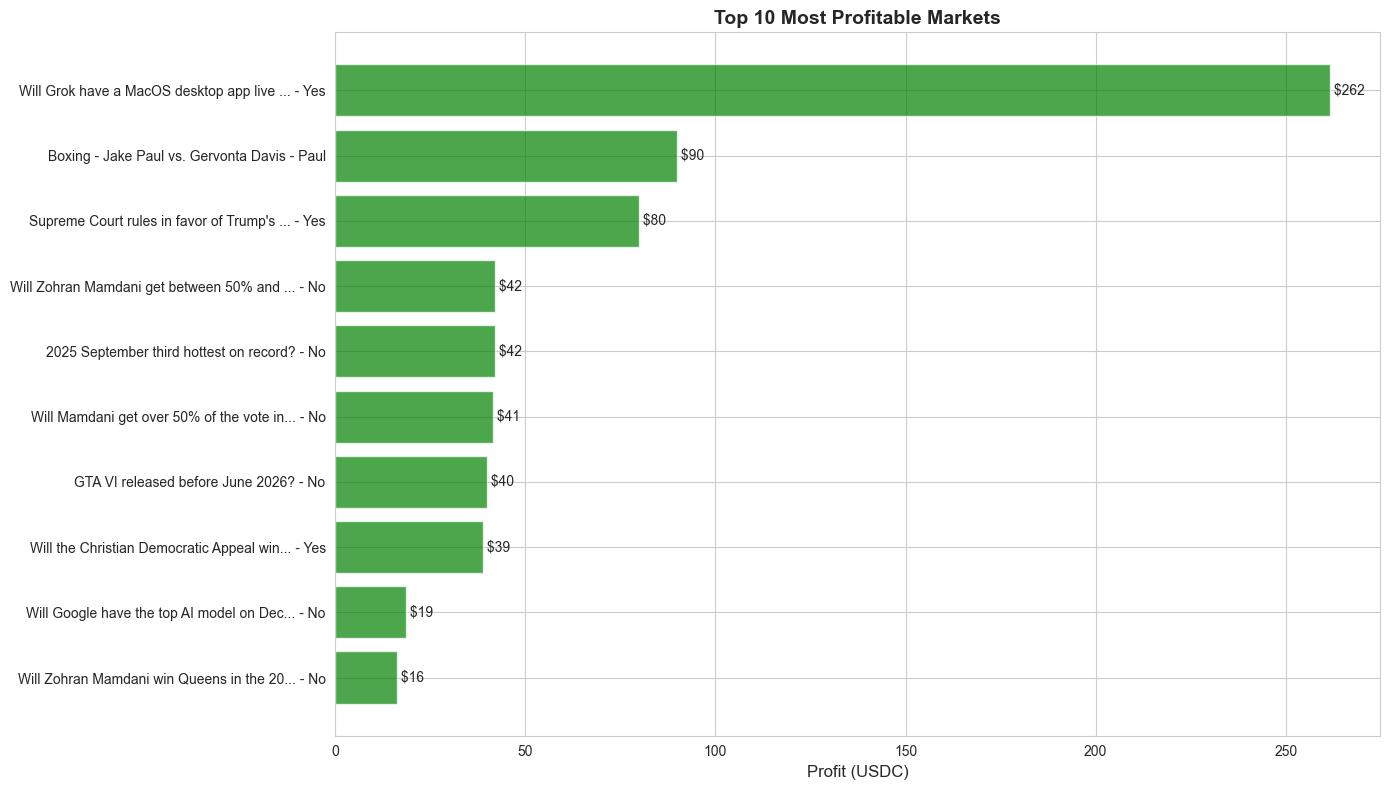

In [9]:
# Visualize top gainers
fig, ax = plt.subplots(figsize=(14, 8))

# Create labels with market name and outcome
labels = [f"{row['title'][:40]}... - {row['outcome']}" if len(row['title']) > 40 
          else f"{row['title']} - {row['outcome']}" 
          for _, row in top_gainers.iterrows()]

y_pos = range(len(labels))

bars = ax.barh(y_pos, top_gainers['pnl'], color='green', alpha=0.7)
ax.set_yticks(y_pos)
ax.set_yticklabels(labels)
ax.set_xlabel('Profit (USDC)', fontsize=12)
ax.set_title('Top 10 Most Profitable Markets', fontsize=14, fontweight='bold')
ax.invert_yaxis()  # Highest profit at top

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, top_gainers['pnl'])):
    ax.text(val, i, f' ${val:,.0f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

## Top 10 Most Unprofitable Markets

In [10]:
top_losers = market_pnl.tail(10).sort_values('pnl')

print("🔴 TOP 10 MOST UNPROFITABLE MARKETS\n")
print("=" * 100)

for idx, row in top_losers.iterrows():
    print(f"\n{row.name + 1}. {row['title']} - {row['outcome']}")
    print(f"   P&L: ${row['pnl']:,.2f}")
    print(f"   Volume: ${row['total_volume']:,.2f} | Trades: {row['trade_count']:.0f}")
    print(f"   Period: {row['first_trade'].strftime('%Y-%m-%d')} to {row['last_trade'].strftime('%Y-%m-%d')}")

print("\n" + "=" * 100)
print(f"Total loss from bottom 10: ${top_losers['pnl'].sum():,.2f}")

🔴 TOP 10 MOST UNPROFITABLE MARKETS


47. Will Lamine Yamal win the 2026 Ballon d'Or? - No
   P&L: $-148.70
   Volume: $155.30 | Trades: 2
   Period: 2025-10-22 to 2025-10-24

54. OpenAI browser in 2025? - No
   P&L: $-138.23
   Volume: $910.15 | Trades: 24
   Period: 2025-10-13 to 2025-10-18

5. Will Trump establish a Gaza “Board of Peace” in 2025? - No
   P&L: $-133.29
   Volume: $362.53 | Trades: 4
   Period: 2025-10-18 to 2025-10-24

53. Will Savannah Louie win Survivor season 49? - Yes
   P&L: $-87.81
   Volume: $87.81 | Trades: 2
   Period: 2025-10-24 to 2025-10-24

13. Will ServisFirst Bancshares (SFBS) beat quarterly earnings? - No
   P&L: $-83.36
   Volume: $83.36 | Trades: 4
   Period: 2025-10-19 to 2025-10-19

25. Will East West Bancorp (EWBC) beat quarterly earnings? - No
   P&L: $-76.72
   Volume: $76.72 | Trades: 4
   Period: 2025-10-19 to 2025-10-19

2. Will Philip Morris International (PM) beat quarterly earnings? - No
   P&L: $-72.73
   Volume: $124.73 | Trades: 7
   Pe

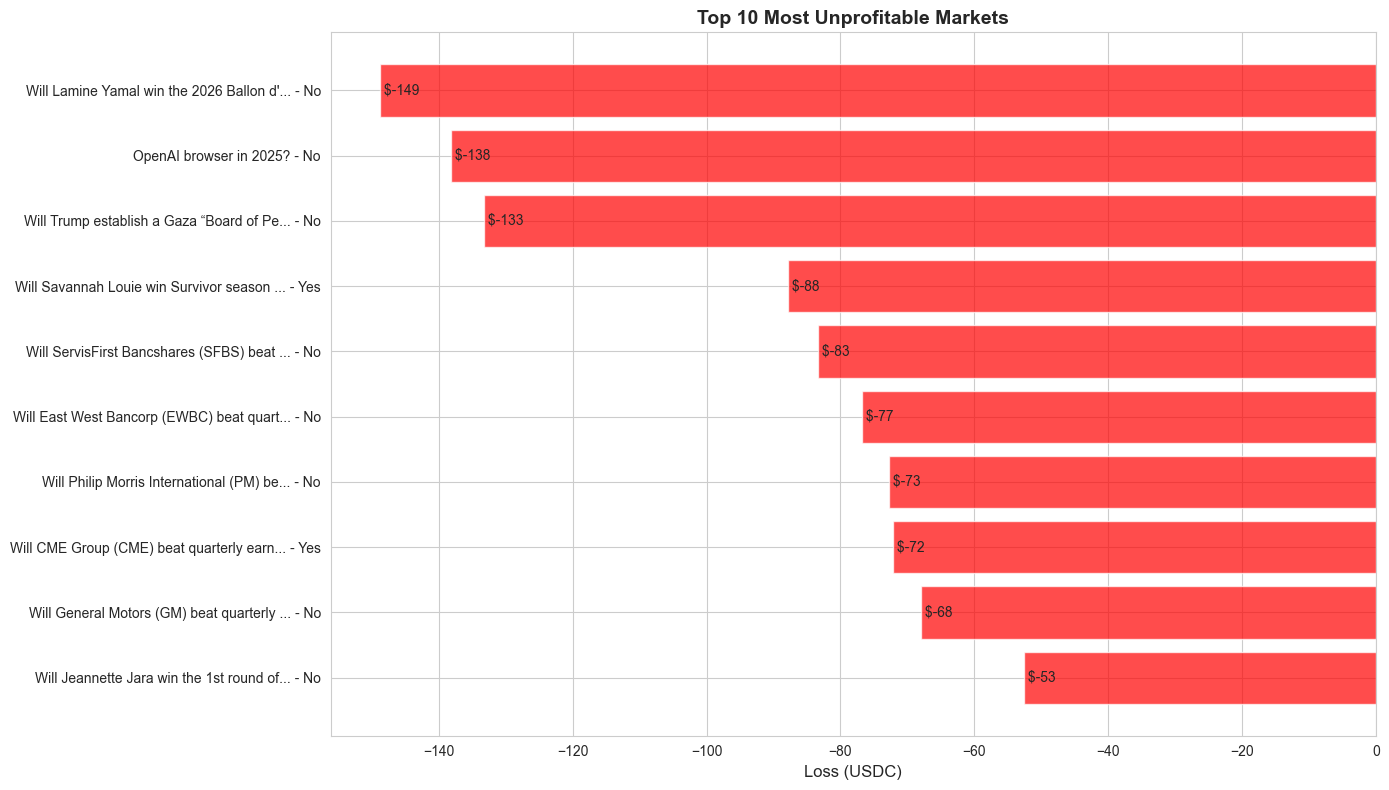

In [11]:
# Visualize top losers
fig, ax = plt.subplots(figsize=(14, 8))

# Create labels with market name and outcome
labels = [f"{row['title'][:40]}... - {row['outcome']}" if len(row['title']) > 40 
          else f"{row['title']} - {row['outcome']}" 
          for _, row in top_losers.iterrows()]

y_pos = range(len(labels))

bars = ax.barh(y_pos, top_losers['pnl'], color='red', alpha=0.7)
ax.set_yticks(y_pos)
ax.set_yticklabels(labels)
ax.set_xlabel('Loss (USDC)', fontsize=12)
ax.set_title('Top 10 Most Unprofitable Markets', fontsize=14, fontweight='bold')
ax.invert_yaxis()  # Highest loss at top

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, top_losers['pnl'])):
    ax.text(val, i, f' ${val:,.0f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

## Summary Statistics

In [12]:
# Overall statistics
total_pnl = market_pnl['pnl'].sum()
positive_markets = len(market_pnl[market_pnl['pnl'] > 0])
negative_markets = len(market_pnl[market_pnl['pnl'] < 0])
neutral_markets = len(market_pnl[market_pnl['pnl'] == 0])

total_profit = market_pnl[market_pnl['pnl'] > 0]['pnl'].sum()
total_loss = market_pnl[market_pnl['pnl'] < 0]['pnl'].sum()

print("📊 SUMMARY STATISTICS")
print("=" * 60)
print(f"\nTimeframe: {START_DATE.strftime('%Y-%m-%d')} to {END_DATE.strftime('%Y-%m-%d')}")
print(f"\nNet P&L: ${total_pnl:,.2f}")
print(f"Total Gross Profit: ${total_profit:,.2f}")
print(f"Total Gross Loss: ${total_loss:,.2f}")
print(f"\nProfit Factor: {abs(total_profit / total_loss) if total_loss != 0 else float('inf'):.2f}")
print(f"\nMarkets traded: {len(market_pnl)}")
print(f"  - Profitable: {positive_markets} ({positive_markets/len(market_pnl)*100:.1f}%)")
print(f"  - Unprofitable: {negative_markets} ({negative_markets/len(market_pnl)*100:.1f}%)")
print(f"  - Breakeven: {neutral_markets} ({neutral_markets/len(market_pnl)*100:.1f}%)")
print(f"\nAverage P&L per market: ${market_pnl['pnl'].mean():,.2f}")
print(f"Median P&L per market: ${market_pnl['pnl'].median():,.2f}")
print(f"\nTotal volume: ${market_pnl['total_volume'].sum():,.2f}")
print(f"Total trades: {market_pnl['trade_count'].sum():,.0f}")
print("\n" + "=" * 60)

📊 SUMMARY STATISTICS

Timeframe: 2025-09-24 to 2025-10-24

Net P&L: $-620.32
Total Gross Profit: $768.18
Total Gross Loss: $-1,388.51

Profit Factor: 0.55

Markets traded: 73
  - Profitable: 24 (32.9%)
  - Unprofitable: 49 (67.1%)
  - Breakeven: 0 (0.0%)

Average P&L per market: $-8.50
Median P&L per market: $-3.00

Total volume: $8,533.45
Total trades: 256



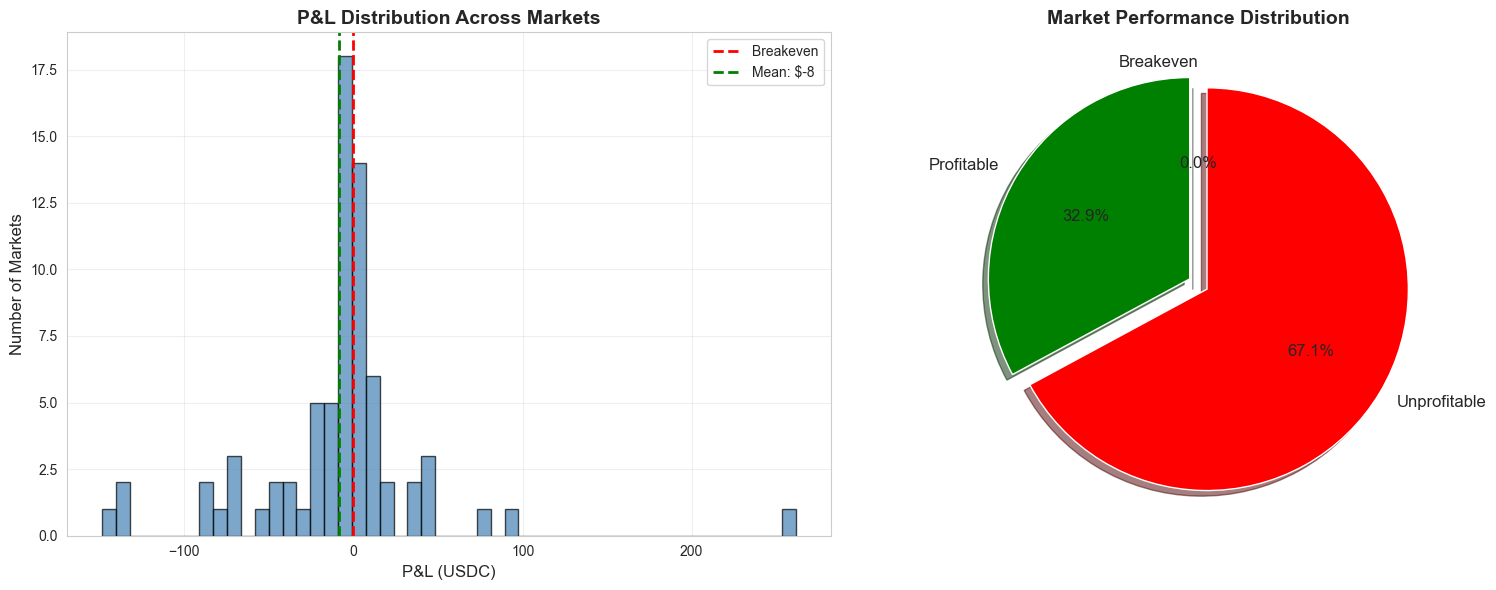

In [13]:
# P&L Distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram
axes[0].hist(market_pnl['pnl'], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Breakeven')
axes[0].axvline(x=market_pnl['pnl'].mean(), color='green', linestyle='--', linewidth=2, label=f"Mean: ${market_pnl['pnl'].mean():,.0f}")
axes[0].set_xlabel('P&L (USDC)', fontsize=12)
axes[0].set_ylabel('Number of Markets', fontsize=12)
axes[0].set_title('P&L Distribution Across Markets', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Pie chart of profitable vs unprofitable
sizes = [positive_markets, negative_markets, neutral_markets]
labels_pie = ['Profitable', 'Unprofitable', 'Breakeven']
colors_pie = ['green', 'red', 'gray']
explode = (0.05, 0.05, 0)

axes[1].pie(sizes, explode=explode, labels=labels_pie, colors=colors_pie, autopct='%1.1f%%',
            shadow=True, startangle=90, textprops={'fontsize': 12})
axes[1].set_title('Market Performance Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()